In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

In [2]:
data = pd.read_csv('data_with_sentiment_v3.csv')
numeric_features = ['Oil_future', 'Oil_future_volume', 'Oil_spot', 'LNG_spot', 'LNG_future_volume', 
            'VIX', 'Gold_future', 'DJI_GI', 'SPX_GI', 'SH', 'EEM', 'Dollar_future', 'XLK', 
            'DJC_E', 'DJC', 'DJ_oil_index', 'DJ_trans', 'DJ_oil_gas_index', 'Unemployment']
target = 'LNG_future'
## check missing value
print('There are %d columns have missing value. \n' % (data.shape[0] - data.dropna(how='any').shape[0]))
print(type(data['Oil_future_volume']))
## transform the datatype
# df['Oil_future_volume'] = df['Oil_future_volume'].apply(lambda x: float(''.join(x.split(','))))
data['Date'] = pd.to_datetime(data['Date'])
print(data.info(verbose=False))
data.head()

There are 0 columns have missing value. 

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Columns: 28 entries, Date to quarter
dtypes: datetime64[ns](1), float64(20), int64(7)
memory usage: 112.6 KB
None


,Date,Oil_future,Oil_future_volume,Oil_spot,LNG_spot,LNG_future,LNG_future_volume,VIX,Gold_future,DJI_GI,...,DJ_trans,DJ_oil_gas_index,Unemployment,sentiment_mode,sentiment_avg,quantile_75,quantile_25,median,year,quarter
0,2020-01-02,61.20,27818,67.13,1.86,2.130,152564,12.47,1513.9,28868.8008,...,10994.31,502.62,3.5,0,0.122699,0.0,0,0,0,0
1,2020-01-03,63.06,68042,69.38,2.09,2.114,138619,14.02,1513.8,28634.8809,...,10911.40,501.30,3.5,0,0.157534,0.0,0,0,0,0
2,2020-01-06,62.93,43309,70.87,2.24,2.149,138798,13.85,1516.9,28703.3809,...,10848.73,505.18,3.5,0,0.069565,0.0,0,0,0,0
3,2020-01-07,62.82,47964,69.60,2.25,2.154,144422,13.79,1527.3,28583.6797,...,10887.56,504.23,3.5,0,0.121857,0.0,0,0,0,0
4,2020-01-08,60.00,67732,69.58,2.17,2.151,207012,13.45,1551.7,28745.0898,...,10983.64,494.90,3.5,0,0.067340,0.0,0,0,0,0


In [3]:
## split the train(202001 - 202109), test(202110 - 202112) and external (202201) dataset
train = data.loc[data['Date'] < '2021-10-01']
val =  data.loc[(data['Date'] >= '2021-10-01') & (data['Date'] < '2022-01-01')]
external_test = data.loc[data['Date'] >= '2022-01-01']

In [4]:
## scale the data
scaler = MinMaxScaler().fit(train[numeric_features+[target]])
train[numeric_features+[target]] = scaler.transform(train[numeric_features+[target]])
val[numeric_features+[target]] = scaler.transform(val[numeric_features+[target]])
external_test[numeric_features+[target]] = scaler.transform(external_test[numeric_features+[target]])
train

,Date,Oil_future,Oil_future_volume,Oil_spot,LNG_spot,LNG_future,LNG_future_volume,VIX,Gold_future,DJI_GI,...,DJ_trans,DJ_oil_gas_index,Unemployment,sentiment_mode,sentiment_avg,quantile_75,quantile_25,median,year,quarter
0,2020-01-02,0.827339,0.098078,0.830083,0.107264,0.136077,0.436993,0.005242,0.065087,0.603334,...,0.464376,0.991778,0.000000,0,0.122699,0.0,0,0,0,0
1,2020-01-03,0.849939,0.267055,0.864097,0.122878,0.132479,0.397050,0.027199,0.064915,0.589601,...,0.455403,0.987538,0.000000,0,0.157534,0.0,0,0,0,0
2,2020-01-06,0.848360,0.163154,0.886621,0.133062,0.140351,0.397562,0.024791,0.070239,0.593623,...,0.448620,1.000000,0.000000,0,0.069565,0.0,0,0,0,0
3,2020-01-07,0.847023,0.182709,0.867423,0.133741,0.141475,0.413672,0.023941,0.088099,0.586595,...,0.452822,0.996949,0.000000,0,0.121857,0.0,0,0,0,0
4,2020-01-08,0.812758,0.265752,0.867120,0.128310,0.140801,0.592951,0.019125,0.130002,0.596071,...,0.463221,0.966982,0.000000,0,0.067340,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,2021-09-24,0.982868,0.130652,0.967347,0.247794,0.821188,0.133318,0.080040,0.460931,0.951425,...,0.826854,0.753493,0.098214,0,0.116822,0.0,0,0,1,0
428,2021-09-27,1.000000,0.157143,0.990325,0.280380,0.974359,0.616143,0.094348,0.466941,0.955615,...,0.840949,0.801959,0.098214,0,0.150000,0.0,0,0,1,0
429,2021-09-28,0.986634,0.169275,1.000000,0.300747,0.971660,0.928136,0.157954,0.433625,0.922188,...,0.824444,0.806038,0.098214,0,0.177122,0.0,0,0,1,0
430,2021-09-29,0.992102,0.143658,0.981255,0.298710,0.884840,0.598760,0.148180,0.427615,0.927514,...,0.816031,0.804497,0.098214,0,0.165000,0.0,0,0,1,0


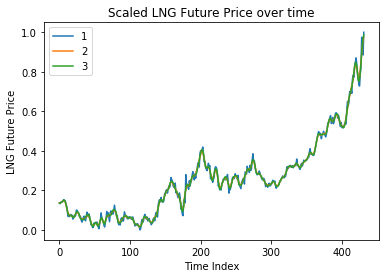

In [5]:
# comparision of the performance of different smoothing parameters
# plt.figure(figsize=(10,10))
plt.plot(range(432),train[target])
plt.plot(savgol_filter(train[target], 5, 1, mode= 'nearest'))
plt.plot(savgol_filter(train[target], 15, 5, mode= 'nearest'))
plt.title('Scaled LNG Future Price over time')
plt.xlabel('Time Index')
plt.ylabel('LNG Future Price')
plt.legend(['1', '2', '3'])
plt.show()

In [6]:
# concat data within a time window - this is based on continues index
def window_features(df, window, k=1):
    for each in numeric_features+[target]:
        df[each] = savgol_filter(df[each], window, k, mode= 'nearest')    
    return df

train = window_features(train, 5)
val = window_features(val, 5)
external_test_new = window_features(external_test, 5)

In [7]:
external_test.iloc[-1,0]

Timestamp('2022-01-31 00:00:00')

# LSTM Model

# Baseline

In [8]:
import copy
new_train = copy.copy(train)
new_val = copy.copy(val)
new_test = copy.copy(external_test_new)
train1 = copy.copy(train)
val1 = copy.copy(val)
test1 = copy.copy(external_test_new)

In [9]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import time
from itertools import product
import os
import random
import re
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import savgol_filter
import matplotlib.pyplot as plot
from sklearn.metrics import mean_squared_error as mse

In [10]:
p_t = train['LNG_future']
p_v = val['LNG_future']
p_e = external_test_new['LNG_future']
train = train.drop(['sentiment_mode','sentiment_avg','quantile_75','quantile_25','median'], axis = 1)
val = val.drop(['sentiment_mode','sentiment_avg','quantile_75','quantile_25','median'], axis = 1)
test = external_test_new.drop(['sentiment_mode','sentiment_avg','quantile_75','quantile_25','median'], axis = 1)

In [11]:
# concat data within a time window
# split training and validation set
df = train.drop(['LNG_future'], axis = 1)

def data_form(data, price, window):
    price = price.to_numpy()
    data = data.iloc[:, 1:]
    X, y = [], []  
    for index in range(len(data) - window):   
        X.append(data[index: index + window]) 
        y.append(price[index + window]) 
    X, y = np.array(X), np.array(y).reshape(-1,1)
    x = torch.from_numpy(X).type(torch.Tensor)
    y = torch.from_numpy(y).type(torch.Tensor)
    return [x, y]

all_data_train = data_form(train, p_t, 5)
all_data_val = data_form(val, p_v, 5)
all_data_ex = data_form(external_test, p_e, 5)

In [12]:
## LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :]) 
        return out

In [13]:
#random seed 
def init_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False       
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

init_random_seed(0)

In [14]:
x_train, y_train= all_data_train[0], all_data_train[1]
x_val, y_val= all_data_val[0], all_data_val[1]
print(x_val.shape)

torch.Size([57, 5, 22])


Training epoch  0 MSE:  0.15748581290245056
Training epoch  20 MSE:  0.013452176935970783
Training epoch  40 MSE:  0.01054839976131916
Training epoch  60 MSE:  0.006814701948314905
Training epoch  80 MSE:  0.0029512192122638226
train 5 rounds in total, this is the 0 th round, RMSE is0.19125231076031923 

Training epoch  0 MSE:  0.08598436415195465
Training epoch  20 MSE:  0.014346844516694546
Training epoch  40 MSE:  0.008726858533918858
Training epoch  60 MSE:  0.003646387718617916
Training epoch  80 MSE:  0.0027955060359090567
train 5 rounds in total, this is the 1 th round, RMSE is0.11549996095709503 

Training epoch  0 MSE:  0.22054927051067352
Training epoch  20 MSE:  0.015333326533436775
Training epoch  40 MSE:  0.011796918697655201
Training epoch  60 MSE:  0.009102589450776577
Training epoch  80 MSE:  0.005849706474691629
train 5 rounds in total, this is the 2 th round, RMSE is0.2626318116672337 

Training epoch  0 MSE:  0.11512766778469086
Training epoch  20 MSE:  0.01468690577

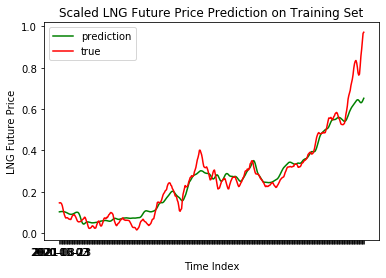

In [15]:
# train
import math
def train(hidden_size, num_epochs, lr, reg, seed=None, plot=True):
    if seed:
        init_random_seed(seed)
    input_dim  = x_train.shape[-1]
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_size, output_dim=1, num_layers=2)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

    hist = np.zeros(num_epochs)
    lstm = []
    mse_sum = 0
    for t in range(num_epochs):
        y_train_pred = model(x_train)
        loss = criterion(y_train_pred, y_train)
        hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        if t % 20 == 0:
            print("Training epoch ", t, "MSE: ", loss.item())
            mse_sum += loss.item()
    mse_train = mse_sum        
    y_train_pred = model(x_train)  
    loss = criterion(y_train_pred, y_train).item()
    y_train_pred = y_train_pred.detach().numpy()
    y_train_true = y_train.detach().numpy()
    
    if plot:
        axis = list(range(len(y_train_pred)))
        plt.plot(axis, y_train_pred, c='g', label='prediction')
        plt.plot(axis, y_train_true, c='r', label='true')
        plt.title('Scaled LNG Future Price Prediction on Training Set')
        plt.xlabel('Time Index')
        plt.ylabel('LNG Future Price')
        plt.xticks(list(range(len(y_train_pred))), ['2020-01-02', '2020-06-03', '2020-10-23', '2021-03-23', '2021-08-13'])
        plt.legend()

    return mse_train, model

# train n times and get the average RMSE
def get_avg_se(run_times, hidden_size, num_epochs, lr, reg):
    train_sum = 0
    for i in range(run_times):
        if i == 0:
            mse_train, model = train(hidden_size, num_epochs, lr, reg, i)
        else:
            mse_train, model = train(hidden_size, num_epochs, lr, reg, i, False)
        print(f'train {run_times} rounds in total, this is the {i} th round, RMSE is{mse_train}', '\n')
    train_sum += math.sqrt(mse_train)
    train_avg = train_sum / run_times
    print(f'average RMSE of training set is {train_avg}')
    return train_avg, model


# train with original features
mse_train, model = get_avg_se(5, 64, 100, 0.01, 0.01)
# torch.save(model.state_dict(), f'/Users/zhang621108/Desktop/LSTM_fulldata.model')


0.15095216


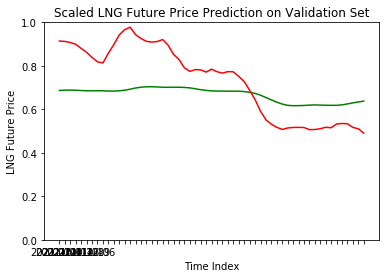

In [16]:
# validation
input_dim  = x_val.shape[-1]


y_val_pred = model(x_val)

y_val_pred = y_val_pred.detach().numpy()
y_val_true = y_val.detach().numpy()


RMSE = mse(y_val_true, y_val_pred, squared=False)
print(RMSE)
if plot:
    axis = list(range(len(y_val_pred)))
    plt.plot(axis, y_val_pred, c='g', label='prediction')
    plt.plot(axis, y_val_true, c='r', label='true')
    plt.ylim(0,1)
    plt.xticks(list(range(len(y_val_pred))), ['2021-10-01', '2021-10-14', '2021-10-26', '2021-11-08','2021-11-19', '2021-12-06'])
    plt.title('Scaled LNG Future Price Prediction on Validation Set')
    plt.xlabel('Time Index')
    plt.ylabel('LNG Future Price')
    plt.show()

# Model with sentiment analysis

In [17]:
all_data_train = data_form(new_train, p_t, 5)
all_data_val = data_form(new_val, p_v, 5)
all_data_ex = data_form(new_test, p_e, 5)
x_train, y_train= all_data_train[0], all_data_train[1]
x_val, y_val= all_data_val[0], all_data_val[1]
print(x_val.shape)

torch.Size([57, 5, 27])


Training epoch  0 MSE:  0.13713327050209045
Training epoch  20 MSE:  0.013962988741695881
Training epoch  40 MSE:  0.010095315054059029
Training epoch  60 MSE:  0.0075246719643473625
Training epoch  80 MSE:  0.003932348918169737
train 5 rounds in total, this is the 0 th round, RMSE is0.17264859518036246 

Training epoch  0 MSE:  0.2384299784898758
Training epoch  20 MSE:  0.013498089276254177
Training epoch  40 MSE:  0.011271027848124504
Training epoch  60 MSE:  0.00881559494882822
Training epoch  80 MSE:  0.005983786657452583
train 5 rounds in total, this is the 1 th round, RMSE is0.2779984772205353 

Training epoch  0 MSE:  0.07628998905420303
Training epoch  20 MSE:  0.012518675066530704
Training epoch  40 MSE:  0.007316097617149353
Training epoch  60 MSE:  0.003658212488517165
Training epoch  80 MSE:  0.002880336018279195
train 5 rounds in total, this is the 2 th round, RMSE is0.10266331024467945 

Training epoch  0 MSE:  0.08195912837982178
Training epoch  20 MSE:  0.0127096017822

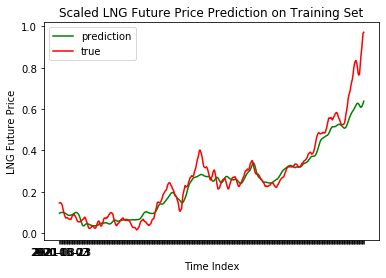

In [18]:
mse_train, model = get_avg_se(5, 64, 100, 0.01, 0.01)

0.1498598


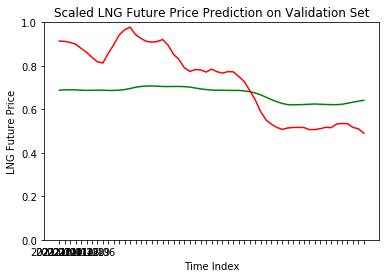

In [19]:
input_dim  = x_val.shape[-1]


y_val_pred = model(x_val)

y_val_pred = y_val_pred.detach().numpy()
y_val_true = y_val.detach().numpy()


RMSE = mse(y_val_true, y_val_pred, squared=False)
print(RMSE)
if plot:
    axis = list(range(len(y_val_pred)))
    plt.plot(axis, y_val_pred, c='g', label='prediction')
    plt.plot(axis, y_val_true, c='r', label='true')
    plt.ylim(0,1)
    plt.xticks(list(range(len(y_val_pred))), ['2021-10-01', '2021-10-14', '2021-10-26', '2021-11-08','2021-11-19', '2021-12-06'])
    plt.title('Scaled LNG Future Price Prediction on Validation Set')
    plt.xlabel('Time Index')
    plt.ylabel('LNG Future Price')
    plt.show()

## Selection on sentiment features

In [20]:
new_train = new_train.drop(['sentiment_mode','quantile_75','quantile_25','median'], axis = 1)
new_val = new_val.drop(['sentiment_mode','quantile_75','quantile_25','median'], axis = 1)
newtest = new_test.drop(['sentiment_mode','quantile_75','quantile_25','median'], axis = 1)
all_data_train = data_form(new_train, p_t, 5)
all_data_val = data_form(new_val, p_v, 5)
all_data_ex = data_form(new_test, p_e, 5)
x_train, y_train= all_data_train[0], all_data_train[1]
x_val, y_val= all_data_val[0], all_data_val[1]
print(x_val.shape)

torch.Size([57, 5, 23])


In [21]:
new_train

,Date,Oil_future,Oil_future_volume,Oil_spot,LNG_spot,LNG_future,LNG_future_volume,VIX,Gold_future,DJI_GI,...,XLK,DJC_E,DJC,DJ_oil_index,DJ_trans,DJ_oil_gas_index,Unemployment,sentiment_avg,year,quarter
0,2020-01-02,0.836063,0.144889,0.848193,0.115547,0.136212,0.421118,0.013543,0.066083,0.598645,...,0.253236,0.675852,0.428465,0.909408,0.459430,0.992574,0.000000,0.122699,0,0
1,2020-01-03,0.840000,0.161815,0.855661,0.120842,0.137292,0.416454,0.017283,0.070685,0.595297,...,0.251288,0.680153,0.430131,0.915211,0.457119,0.993608,0.000000,0.157534,0,0
2,2020-01-06,0.837084,0.195350,0.863069,0.125051,0.138237,0.447646,0.020059,0.083668,0.593845,...,0.251557,0.676335,0.428310,0.913415,0.456888,0.988649,0.000000,0.069565,0,0
3,2020-01-07,0.833171,0.215237,0.863401,0.124779,0.139856,0.476425,0.020258,0.101391,0.594879,...,0.254199,0.672027,0.426355,0.914222,0.457570,0.986035,0.000000,0.121857,0,0
4,2020-01-08,0.823645,0.195082,0.856266,0.119077,0.144040,0.541718,0.016121,0.122858,0.597097,...,0.258701,0.661245,0.423676,0.912883,0.458923,0.982239,0.000000,0.067340,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,2021-09-24,0.980365,0.154046,0.970854,0.273048,0.856770,0.446793,0.109817,0.465190,0.939689,...,0.944278,0.967748,0.978089,0.942161,0.819412,0.760707,0.098214,0.116822,1,0
428,2021-09-27,0.987096,0.151486,0.978927,0.279294,0.888214,0.512071,0.114605,0.448772,0.941244,...,0.935028,0.979123,0.983662,0.968493,0.824665,0.781802,0.098214,0.150000,1,0
429,2021-09-28,0.991567,0.154013,0.985820,0.284046,0.930409,0.585962,0.127383,0.454199,0.930431,...,0.918723,0.988999,0.987987,0.982257,0.819644,0.790275,0.098214,0.177122,1,0
430,2021-09-29,0.994241,0.161750,0.990385,0.293007,0.966172,0.689990,0.142655,0.458389,0.919229,...,0.902172,0.996037,0.990276,0.993092,0.812261,0.796653,0.098214,0.165000,1,0


Training epoch  0 MSE:  0.056255873292684555
Training epoch  20 MSE:  0.01193282287567854
Training epoch  40 MSE:  0.0073480019345879555
Training epoch  60 MSE:  0.0038016559556126595
Training epoch  80 MSE:  0.0026508455630391836
train 5 rounds in total, this is the 0 th round, RMSE is0.08198919962160289 

Training epoch  0 MSE:  0.10374601930379868
Training epoch  20 MSE:  0.013366426341235638
Training epoch  40 MSE:  0.009576314128935337
Training epoch  60 MSE:  0.003562035271897912
Training epoch  80 MSE:  0.002625411842018366
train 5 rounds in total, this is the 1 th round, RMSE is0.13287620688788593 

Training epoch  0 MSE:  0.08934927731752396
Training epoch  20 MSE:  0.013982128351926804
Training epoch  40 MSE:  0.009376333095133305
Training epoch  60 MSE:  0.005762739107012749
Training epoch  80 MSE:  0.0034974117297679186
train 5 rounds in total, this is the 2 th round, RMSE is0.12196788960136473 

Training epoch  0 MSE:  0.12280518561601639
Training epoch  20 MSE:  0.0131586

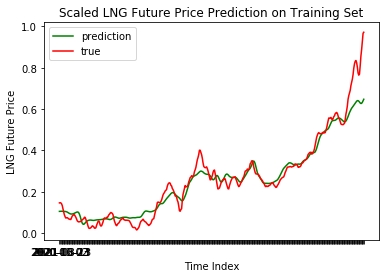

In [22]:
mse_train, model = get_avg_se(5, 64, 100, 0.01, 0.01)

0.14046347


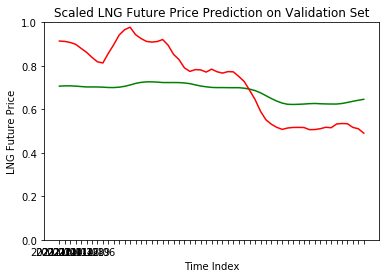

In [23]:
input_dim  = x_val.shape[-1]


y_val_pred = model(x_val)

y_val_pred = y_val_pred.detach().numpy()
y_val_true = y_val.detach().numpy()


RMSE = mse(y_val_true, y_val_pred, squared=False)
print(RMSE)
if plot:
    axis = list(range(len(y_val_pred)))
    plt.plot(axis, y_val_pred, c='g', label='prediction')
    plt.plot(axis, y_val_true, c='r', label='true')
    plt.ylim(0,1)
    plt.xticks(list(range(len(y_val_pred))), ['2021-10-01', '2021-10-14', '2021-10-26', '2021-11-08','2021-11-19', '2021-12-06'])
    plt.title('Scaled LNG Future Price Prediction on Validation Set')
    plt.xlabel('Time Index')
    plt.ylabel('LNG Future Price')
    plt.show()

In [24]:
# x, y= all_data[0], all_data[1]
# print(x.shape)
# y_pred = model(x)
# y_pred = y_pred.tolist()
# d = pd.read_csv('data_with_sentiment_v2.csv')
# y_pre = []
# for i in range(len(y_pred)):
#     y_pre.append(y_pred[i][0])
# y_pre.append(0.5897388167381287)
# y_pre.append(0.5853999257087708)
# y_pre.append(0.5786902904510498)
# y_pre.append(0.5700615954399109)
# y_pre.append(0.5886902904510498)
# d['predict_y']= y_pre
# d.to_csv('data_prediction.csv')

## back-test

In [25]:
# # get the data of last 10 days to predict the next day
# print(external_test.iloc[0, 0])
# latest_x = np.array(external_test_reduced.iloc[:, 1:])
# latest_x = torch.Tensor(latest_x)
# latest_x = latest_x.unsqueeze(0)
# latest_x.shape

# Feature selection

In [26]:
# selecting feature with three algorithms

def feature_select(data):
    
    X = data.iloc[:, 2:]
    Y = data.iloc[:, 1]
    names = data.columns[2:]
    
    def ridge():
        ridge = Ridge(alpha=5)
        ridge.fit(X, Y)
        scores = [i[0] for i in scaler.fit_transform([[np.abs(i)] for i in ridge.coef_])]
        return scores
    
    def randomForest():
        rf = RandomForestRegressor()
        rf.fit(X, Y)
        scores = scaler.fit_transform(list(map(lambda x: [round(x, 4)], rf.feature_importances_)))
        scores = [i[0] for i in scores]
        return scores
    
    def cov():
        scores = [np.abs(i) for i in data.corr()['LNG_future'][1:]]
        return scores 
    
    crit1, crit2, crit3 = ridge(), randomForest(), cov()
    all_crit = list(zip(names, [(i[0]+i[1]+i[2])/3 for i in list(zip(crit1, crit2, crit3))]))
    return all_crit


all_crit_new = feature_select(new_train)
l=[]
for i in sorted(all_crit_new, key= lambda x:x[1]):
    l.append(i)
df_f = pd.DataFrame(l, columns=['Feature', 'score'])
df_f

,Feature,score
0,quarter,0.057644
1,LNG_future_volume,0.083690
2,sentiment_avg,0.087010
3,Oil_future_volume,0.094573
4,Gold_future,0.167056
5,VIX,0.170950
6,Dollar_future,0.220402
7,LNG_spot,0.221458
8,year,0.231108
9,EEM,0.274327


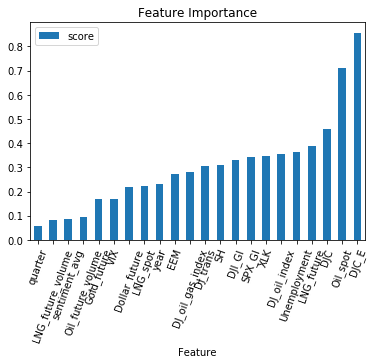

In [27]:
df_f.plot.bar(x="Feature", y="score", rot=70, title="Feature Importance")
plot.show(block=True)

Training epoch  0 MSE:  0.16249237954616547
Training epoch  20 MSE:  0.012892475351691246
Training epoch  40 MSE:  0.010051592253148556
Training epoch  60 MSE:  0.007598663680255413
Training epoch  80 MSE:  0.0038634270895272493
train 5 rounds in total, this is the 0 th round, RMSE is0.19689853792078793 

Training epoch  0 MSE:  0.14910216629505157
Training epoch  20 MSE:  0.014066841453313828
Training epoch  40 MSE:  0.010464677587151527
Training epoch  60 MSE:  0.00815558061003685
Training epoch  80 MSE:  0.004999007098376751
train 5 rounds in total, this is the 1 th round, RMSE is0.18678827304393053 

Training epoch  0 MSE:  0.10649935156106949
Training epoch  20 MSE:  0.013010402210056782
Training epoch  40 MSE:  0.00935952179133892
Training epoch  60 MSE:  0.007010055240243673
Training epoch  80 MSE:  0.0034384485334157944
train 5 rounds in total, this is the 2 th round, RMSE is0.13931777933612466 

Training epoch  0 MSE:  0.08334340155124664
Training epoch  20 MSE:  0.01395616587

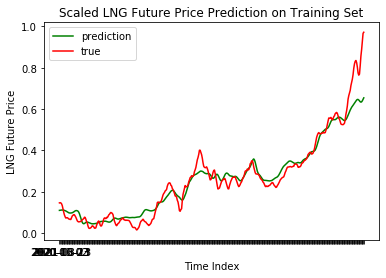

In [28]:
# delete features with low score
features_new = [i[0] for i in all_crit_new if i[0] not in ['Gold_future', 'Oil_future_volume','LNG_future_volume']]
train_reduced = new_train.loc[:, features_new]
all_train_reduced = data_form(train_reduced, p_t, 5)
x_train, y_train= all_train_reduced[0], all_train_reduced[1]
RMSE, model = get_avg_se(5, 64, 100, 0.01, 0.01)

0.14461124


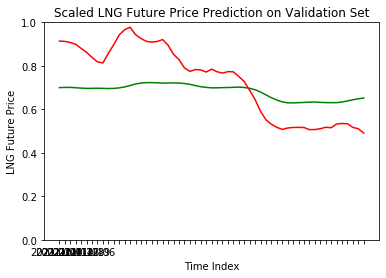

In [29]:
val_reduced = new_val.loc[:, features_new]
all_val_reduced = data_form(val_reduced, p_v, 5)
x_val, y_val= all_val_reduced[0], all_val_reduced[1]
input_dim  = x_val.shape[-1]
y_val_pred = model(x_val)
y_val_pred = y_val_pred.detach().numpy()
y_val_true = y_val.detach().numpy()
RMSE = mse(y_val_true, y_val_pred, squared=False)
print(RMSE)
if plot:
    axis = list(range(len(y_val_pred)))
    plt.plot(axis, y_val_pred, c='g', label='prediction')
    plt.plot(axis, y_val_true, c='r', label='true')
    plt.ylim(0,1)
    plt.xticks(list(range(len(y_val_pred))), ['2021-10-01', '2021-10-14', '2021-10-26', '2021-11-08','2021-11-19', '2021-12-06'])
    plt.title('Scaled LNG Future Price Prediction on Validation Set')
    plt.xlabel('Time Index')
    plt.ylabel('LNG Future Price')
    plt.show()

In [31]:
# # get the data of last 10 days to predict the next day
# print(external_test.iloc[0, 0])
# latest_x = np.array(external_test_reduced.iloc[:, 1:])
# latest_x = torch.Tensor(latest_x)
# latest_x = latest_x.unsqueeze(0)
# latest_x.shape

In [32]:
# # prediction result
# latest_y = model(latest_x)
# y = latest_y.detach().numpy()
# # latest_y = scaler_price.inverse_transform(latest_y)
# print(f'we predict next day (2022-02-01) LNG future price will be {latest_y}')

In [33]:
# import time
# import datetime
# def predict(date, dataset):
#     date = time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple())
#     d = int(date + 28800)
#     for i in range(dataset.shape[0]):
#         if d == dataset['Date'].tolist()[i].value//1000000000:
#             return dataset['LNG_future'].tolist()[i]
#         else: i += 1
# predict('2021-12-29', test)

# from attention

In [34]:
import numpy as np
import pandas as pd
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Model
from attention import Attention
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 

In [35]:
import tensorflow as tf
all_data_train = data_form(train1, p_t, 5)
all_data_val = data_form(val1, p_v, 5)

x_train, y_train = all_data_train
x_val, y_val = all_data_val
train_x = x_train.numpy()
train_y = y_train.numpy()
val_x = x_val.numpy()
val_y = y_val.numpy()


In [38]:
# Dummy data. There is nothing to learn in this example.
time_steps, input_dim, output_dim = 5, 27, 1
# compile the model.
model_input = Input(shape=(time_steps, input_dim))
model = LSTM(256, return_sequences=True)(model_input)
model = Attention(units=256)(model)
model = Dense(4, activation='relu')(model)
model = Dense(output_dim)(model)
model = Model(model_input, model)
model.compile(loss='mae', optimizer='adam')
model.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 27)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 256)            290816    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               196608    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 488,457
Trainable params: 488,457
Non-trainable params: 0
_________________________________________________________________


In [39]:
# train.
model.fit(train_x, train_y, epochs=30)
# model.save('/Users/zhang621108/Desktop/LSTM_attention.model')
# model.save('/Users/zhang621108/Desktop/LSTM_attention.model')
#model_h5 = load_model('test_model.h5', custom_objects={'Attention': Attention})
pred_t = model.predict(train_x)
rmse_train = math.sqrt(mean_squared_error(train_y, pred_t))
print(f'average RMSE of training set is {rmse_train}')
pred_v = model.predict(val_x)
rmse_val = math.sqrt(mean_squared_error(val_y, pred_v))
print(f'average RMSE of validation set is {rmse_val}')

Epoch 1/30
14/14 [==============================] - 4s 25ms/step - loss: 0.1291
Epoch 2/30
14/14 [==============================] - 0s 22ms/step - loss: 0.0667
Epoch 3/30
14/14 [==============================] - 0s 23ms/step - loss: 0.0831
Epoch 4/30
14/14 [==============================] - 0s 25ms/step - loss: 0.0410
Epoch 5/30
14/14 [==============================] - 0s 30ms/step - loss: 0.0327
Epoch 6/30
14/14 [==============================] - 0s 26ms/step - loss: 0.0297
Epoch 7/30
14/14 [==============================] - 0s 23ms/step - loss: 0.0382
Epoch 8/30
14/14 [==============================] - 0s 23ms/step - loss: 0.0329
Epoch 9/30
14/14 [==============================] - 0s 31ms/step - loss: 0.0289
Epoch 10/30
14/14 [==============================] - 0s 29ms/step - loss: 0.0310
Epoch 11/30
14/14 [==============================] - 0s 28ms/step - loss: 0.0297
Epoch 12/30
14/14 [==============================] - 0s 26ms/step - loss: 0.0283
Epoch 13/30
14/14 [==================

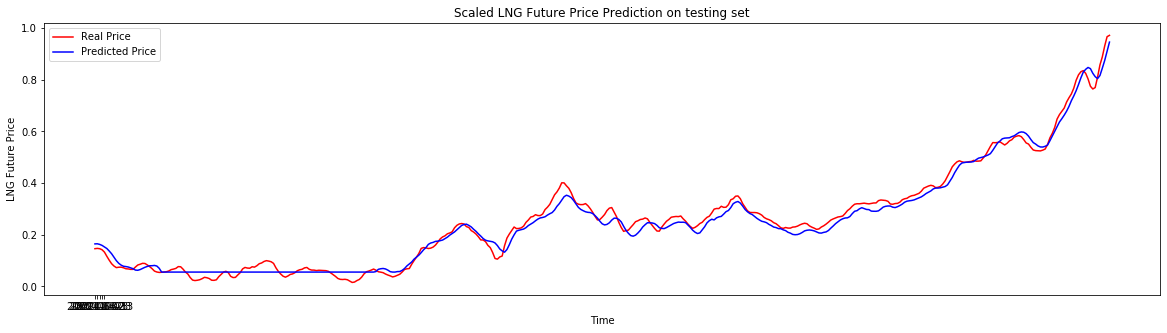

In [40]:
#####plot for training set
plt.figure(figsize=(20, 5))
plt.plot(train_y, color = 'red', label = 'Real Price')
plt.plot(pred_t, color = 'blue', label = 'Predicted Price')
plt.title('Scaled LNG Future Price Prediction on testing set')
plt.xticks(list(range(5)), ['2020-01-02', '2020-06-03', '2020-10-23', '2021-03-23', '2021-08-13'])
plt.xlabel('Time')
plt.ylabel('LNG Future Price')
plt.legend()
plt.show()

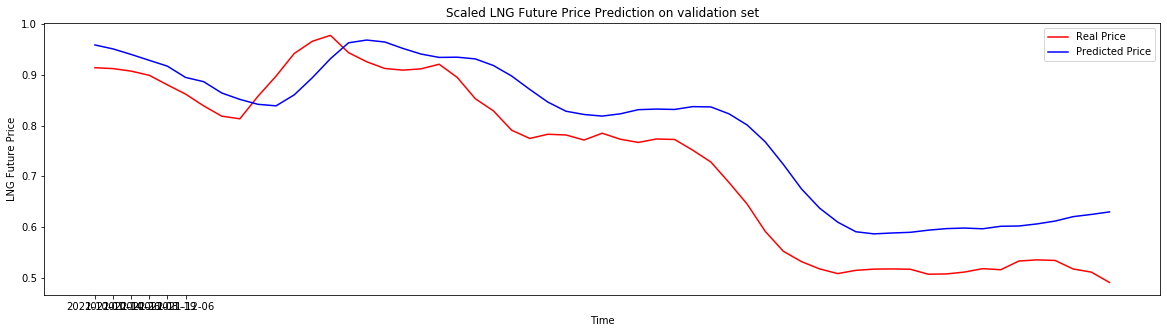

In [41]:
#####plot for validation set
plt.figure(figsize=(20, 5))
plt.plot(val_y, color = 'red', label = 'Real Price')
plt.plot(pred_v, color = 'blue', label = 'Predicted Price')
plt.title('Scaled LNG Future Price Prediction on validation set')
plt.xticks(list(range(6)), ['2021-10-01', '2021-10-14', '2021-10-26', '2021-11-08','2021-11-19', '2021-12-06'])
plt.xlabel('Time')
plt.ylabel('LNG Future Price')
plt.legend()
plt.show()

In [42]:
# test.
x_test, y_test= all_data_ex
test_x = x_test.numpy()
test_y = y_test.numpy()
test_pred = model.predict(test_x)
mean_squared_error(test_y, test_pred)

0.015300193

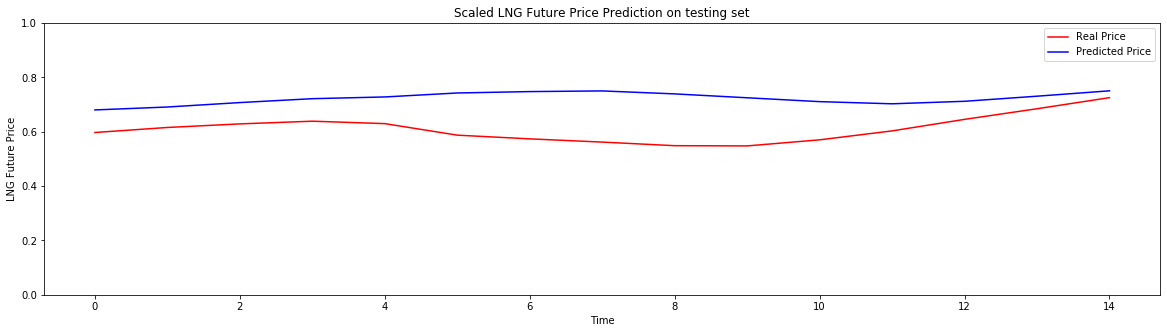

In [43]:
#####plot for test set
plt.figure(figsize=(20, 5))
plt.plot(test_y, color = 'red', label = 'Real Price')
plt.plot(test_pred, color = 'blue', label = 'Predicted Price')
plt.title('Scaled LNG Future Price Prediction on testing set')
plt.ylim(0,1)
plt.xlabel('Time')
plt.ylabel('LNG Future Price')
plt.legend()
plt.show()